In [192]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re

抓股票代號

In [193]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [194]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(20) #固定種子複現結果
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y", start="2018-01-01", end="2020-12-31")
    US10_stocks_prices[stock] = historical_data

In [195]:
US10_Stocks

['CI', 'VRTX', 'ZTS', 'HD', 'MCD', 'GILD', 'SCHW', 'WMT', 'DIS', 'SYK']

利用股價生成日報酬

In [196]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [197]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [198]:
pd.DataFrame(US10_stocks_returns)

,CI,VRTX,ZTS,HD,MCD,GILD,SCHW,WMT,DIS,SYK
0,0.016785,-0.005886,0.004598,0.005212,-0.004214,0.007557,0.001555,0.008723,0.004293,0.005637
1,0.005244,0.006973,0.005964,0.007936,0.007015,-0.010179,0.005629,0.000905,-0.000445,-0.000315
2,0.016953,0.017116,0.011443,0.010446,0.002015,0.008390,0.003860,0.005927,-0.005435,0.014615
3,-0.011066,0.007708,0.011996,-0.002389,-0.000689,-0.001610,0.004422,0.014781,-0.014334,0.013660
4,-0.001681,-0.005609,0.011719,0.005520,-0.002242,0.049731,0.021057,-0.012007,-0.000727,-0.015191
...,...,...,...,...,...,...,...,...,...,...
749,0.020567,0.004002,-0.012235,-0.000852,0.000472,0.006667,0.013749,-0.006796,0.018187,0.004420
750,-0.000754,-0.005851,0.005443,0.004114,-0.002971,-0.005403,-0.005540,0.001955,0.001037,0.003089
751,0.016748,-0.008488,0.010391,-0.006164,0.012441,-0.003154,0.016904,0.011986,0.029529,0.006243
752,0.009349,0.004388,0.004495,-0.011365,-0.006121,-0.001055,-0.007556,-0.006335,-0.008722,0.009684


計算統計數字

In [199]:
#計算平均報酬
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]

mean_returns = pd.Series(US10_stocks_expected_return)
mean_returns

CI      0.008042
VRTX    0.521679
ZTS     1.330430
HD      0.516866
MCD     0.314487
GILD   -0.147648
SCHW    0.063778
WMT     0.552950
DIS     0.666298
SYK     0.586799
dtype: float64

In [200]:
#共變異數矩陣
cov_matrix = pd.DataFrame(US10_stocks_returns).cov()
cov_matrix

,CI,VRTX,ZTS,HD,MCD,GILD,SCHW,WMT,DIS,SYK
CI,0.000595,0.000215,0.000252,0.000255,0.000205,0.000139,0.000282,0.000122,0.000242,0.000289
VRTX,0.000215,0.000528,0.000220,0.000205,0.000139,0.000209,0.000166,0.000131,0.000171,0.000221
ZTS,0.000252,0.000220,0.000332,0.000216,0.000182,0.000137,0.000192,0.000105,0.000180,0.000248
HD,0.000255,0.000205,0.000216,0.000363,0.000215,0.000131,0.000222,0.000138,0.000224,0.000234
MCD,0.000205,0.000139,0.000182,0.000215,0.000299,0.000082,0.000178,0.000092,0.000201,0.000232
GILD,0.000139,0.000209,0.000137,0.000131,0.000082,0.000344,0.000142,0.000106,0.000109,0.000138
SCHW,0.000282,0.000166,0.000192,0.000222,0.000178,0.000142,0.000593,0.000127,0.000276,0.000262
WMT,0.000122,0.000131,0.000105,0.000138,0.000092,0.000106,0.000127,0.000235,0.000099,0.000095
DIS,0.000242,0.000171,0.000180,0.000224,0.000201,0.000109,0.000276,0.000099,0.000443,0.000257
SYK,0.000289,0.000221,0.000248,0.000234,0.000232,0.000138,0.000262,0.000095,0.000257,0.000446


In [201]:
# 建立報酬率及標準差函數
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

# 建立隨機投資組合
# 自訂投資組合數
num_portfolios = 100000

def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((10,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(US10_Stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return) / portfolio_std_dev
    return results, weights_record

In [202]:
# SAMPLE：隨機投資組合

results = np.zeros((10,num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(US10_Stocks))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_std_dev
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return) / portfolio_std_dev

print('-' * 100)
print('平均報酬：\n',mean_returns )
print('-' * 100)
print('投組權重：', weights_record[0])
print('-' * 100)
print('報酬率：', results[1][0])
print('-' * 100)
print('標準差：', results[0][0])
print('-' * 100)

----------------------------------------------------------------------------------------------------
平均報酬：
 CI      0.008042
VRTX    0.521679
ZTS     1.330430
HD      0.516866
MCD     0.314487
GILD   -0.147648
SCHW    0.063778
WMT     0.552950
DIS     0.666298
SYK     0.586799
dtype: float64
----------------------------------------------------------------------------------------------------
投組權重： [0.14461047 0.01036881 0.11743179 0.06478171 0.07508499 0.0307909
 0.1578841  0.14912844 0.15349468 0.0964241 ]
----------------------------------------------------------------------------------------------------
報酬率： 0.46674243559771494
----------------------------------------------------------------------------------------------------
標準差： 0.014950907878442872
----------------------------------------------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


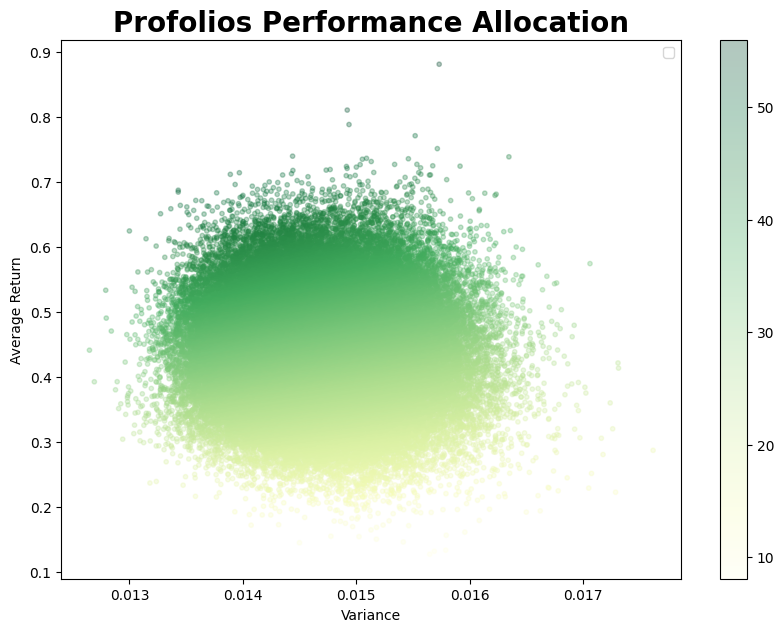

In [203]:
# 投資組合散佈圖

def profolios_allocation(mean_returns, cov_matrix, num_portfolios):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix)
      
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Profolios Performance Allocation', fontsize=20,fontweight='bold',)
    plt.xlabel('Variance')
    plt.ylabel('Average Return')
    plt.legend(labelspacing=0.8)
    plt.show()
    
profolios_allocation(mean_returns, cov_matrix, num_portfolios)

In [204]:
# 建立風險函數
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# 找出投資組合中最小風險
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到相同投資組合報酬率下最小的風險
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到效率前緣樣本
def efficient_profolios(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

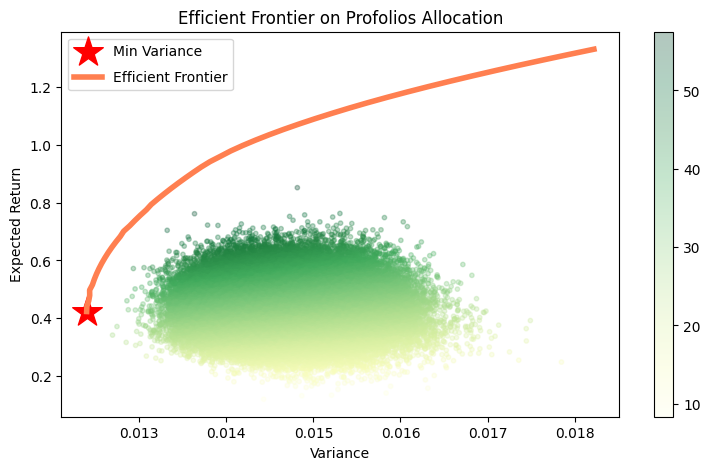

In [205]:
def display_efficient_frontier(mean_returns, cov_matrix, num_portfolios):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix)
     
    #點出所有投組報酬率及風險
    plt.figure(figsize=(9, 5))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    #找出最小風險投資組合及其報酬率
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol['x'], mean_returns, cov_matrix)
    
    #點出最小風險之投資組合
    plt.scatter(sdp_min,rp_min,marker='*',color='red',s=500, label='Min Variance')

    #畫出所有投組樣本的效率前緣線    
    target = np.linspace(rp_min, mean_returns.max(), 50)
    efficient_portfolios = efficient_profolios(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], 
             target, linestyle='-', color='coral',linewidth=4, label='Efficient Frontier') 
    plt.title('Efficient Frontier on Profolios Allocation')
    plt.xlabel('Variance')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.9 ,loc ='upper left')
    plt.show()
    
display_efficient_frontier(mean_returns, cov_matrix, num_portfolios)

切線法

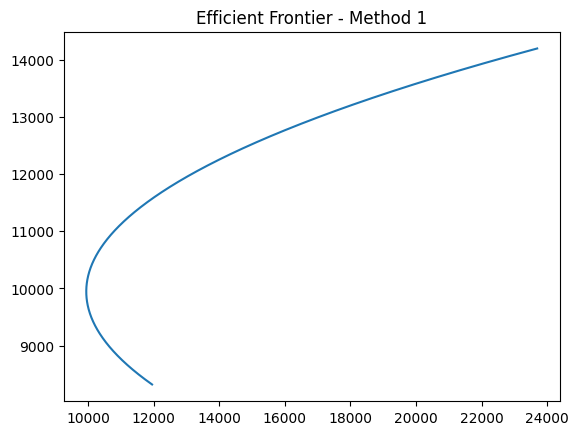

In [206]:
f = mean_returns.values

#建立不同的無風險利率(-1 ~ 1)
Rfs = np.linspace(-1, 1, 1000)

weights = []
for Rf in Rfs:
    Rf = np.full((f.shape[0], 1), Rf)
    f = f.reshape(10, 1)
    Rbar = f + Rf
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    V_inv_Rbar = np.dot(V_inv, Rbar)

    # 計算 V^(-1) * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    ones_vector = np.ones((10, 1))
    V_inv_ones = np.dot(V_inv, ones_vector)

    # 計算 Rf * (V^(-1) * 1)
    Rf_V_inv_ones = Rf * V_inv_ones
    Z = V_inv_Rbar - Rf_V_inv_ones

    # 計算 Z.T * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    Z_transpose = Z.T
    Z_dot_ones = np.dot(Z_transpose, ones_vector)

    # 最後計算 X
    X = V_inv_Rbar - Rf_V_inv_ones / Z_dot_ones
    weights.append(X)


vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

plt.title('Efficient Frontier - Method 1')
plt.plot(vars, fp)


另一種切線法?

C:\Users\USER\AppData\Local\Temp\ipykernel_2612\2039454610.py:35: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = opt.minimize(get_Varp, init_h, method='SLSQP', bounds=bound, constraints=conditions)


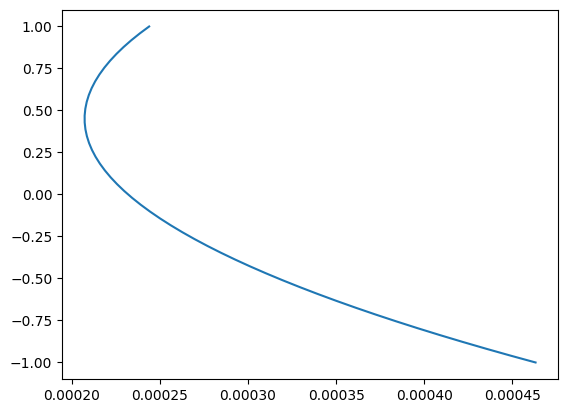

In [210]:
#定義取得fp及Varp的函數
def get_fp(h):
    return np.dot(h.T, f)

def get_Varp(h):
    return np.dot(np.dot(h.T, cov_matrix.values), h)

#引入規劃求解套件
import scipy.optimize as opt


#定義限制式1，h的總和要為1
def constraint1(h):
    return np.sum(h) - 1

#定義限制式2，fp要等於我們設定的目標報酬率(即Rf)
def constraint2(h):
    return get_fp(h) - Rf

#設定h的權重要在-1~1之間
bound = tuple((-1,1) for hi in h)


#將兩個限制式打包成一個tuple
conditions = ({'type':'eq', 'fun':constraint1}, 
              {'type':'eq', 'fun':constraint2})

#隨便給一個求解的起始值(每個都先給0.1)
init_h = np.full((f.shape[0], 1), 1/f.shape[0])

#先設定Rf範圍(-1~1)，再各別求最佳解
Rfs = np.linspace(-1, 1, 50)
weights = []
for idx, Rf in enumerate(Rfs):
    result = opt.minimize(get_Varp, init_h, method='SLSQP', bounds=bound, constraints=conditions)
    weights.append(result.x)

plt.plot([get_Varp(h) for h in weights], [get_fp(h) for h in weights])


切火腿法

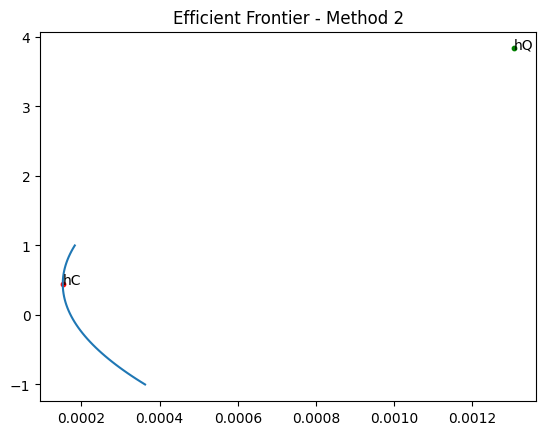

In [211]:
f = mean_returns.values
f = f.reshape(10, 1)
#建立不同的無風險利率(-1 ~ 1)
Rfs = np.linspace(-1, 1, 50)

weights = []
e = np.ones((10, 1))

for u in Rfs:
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    A = e.T @ V_inv @ e
    B = e.T @ V_inv @ f
    C = f.T @ V_inv @ f
    D = (A @ C) - (B ** 2)
    _lambda = (C - (u * B)) / D
    _gamma = ((A * u) - B) / D
    h = (_lambda * V_inv @ e) + (_gamma * V_inv @ f)
    weights.append(h)

hC = (np.linalg.inv(cov_matrix.values) @ e) / (e.T @ np.linalg.inv(cov_matrix.values) @ e)
hQ = (np.linalg.inv(cov_matrix.values) @ f) / (f.T @ np.linalg.inv(cov_matrix.values) @ e)

hC_point = (np.dot(hC.T, cov_matrix.values) @ hC, np.dot(hC.T, f))
hQ_point = (np.dot(hQ.T, cov_matrix.values) @ hQ, np.dot(hQ.T, f))

vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

fig, ax = plt.subplots()
plt.title('Efficient Frontier - Method 2')
plt.scatter(*hC_point, c='red', s=10)
plt.annotate('hC', xy=hC_point)
plt.scatter(*hQ_point, c='green', s=10, label='QML')
plt.annotate('hQ', xy=hQ_point)
plt.plot(vars, fp)